# Using LDA and Jensen-Shannon Distance (JSD) to group similar newspaper articles 


Many researchers have the problem that their data sets or automated set annotations contain articles that are irrelevant to their research question. For example, if the goal is to find articles on return migration, researchers have to deal with some ambiguous search terms. The German words "Heimkehr" (returning home) or "Rückkehr" (returning back) lead to many articles that are relevant to the research question, but also to articles that are not relevant (e.g. return from a mountain tour, work, etc.). By using topic models and document similarity measurements, this notebook allows me to exclude these articles without combining the word "Heimkehr" with other search terms. Furthermore, the same code can also be used to remove or prefer a certain genre, e.g. advertising, sports news, etc.

To give another example: If I want to create a collection of articles about the disease cancer, one of the important German words for cancer is "Krebs". But "Krebs" in German is also a common surname, an animal (crab) or a sign of the zodiac.

The main purpose of this notebook is to take into account the context of articles in order to automatically refine a search query. This means that even ambiguous words can be used for the search without having to combine them with other words, making the search less influenced by the researcher's prior knowledge and avoiding a too narrow tunnel vision. 


#### So how is this working? 

Given a manually annotated collection of articles containing relevant as well as non relevant articles, this program will get the topic distribution of each document using LDA (gensim library). These topic distributions serve as a comparison for other, unseen articles, in order to automatically distinguish between relevant and non-relevant articles. The annotations are used for evaluation and counting the relevance probability for an unseen article. 

For the comparison, the Jensen-Shannon distance method is used to measure the similarity between the topic distribution of an unseen article and the topic distribution of the training corpus. Therefore, the topic distribution of each new article will be compared to the topic distribution of the articles in the trained corpus. Then, for each unseen article, the 10 most similar articles from the training corpus are being extracted. These articles carry the information about the manually assigned relevancy. If 60 precent of the automatically found similar articles were annotated as relevant, the new article will be marked as relevant. Otherwise it will be marked as irrelevant. Using two different datasets (one about cancer and one about return migration), the average score of correct selected articles is between 80 and 90 percent. 

Read more about <a href="https://monkeylearn.com/blog/introduction-to-topic-modeling/" target="_blank">Topic Modeling</a> and the <a href="https://axialcorps.wordpress.com/tag/jensen-shannon-divergence/" target="_blank">Jensen-Shannon distance method</a>.


Acknowledgments:

This work has been inspired by Selva Prabhakaran's <a href="https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/" target="_blank">topic modeling tutorials</a> and a notebook on <a href="https://www.kaggle.com/ktattan/lda-and-document-similarity" target="_blank">LDA and document similarity</a> and was supported by the European Union's Horizon 2020 research and innovation programme under grant 770299 (NewsEye).


## Step by step...
* [Prepare a small manually annotated collection](#1-bullet)
* [Install packages in command line](#2-bullet)
* [Import packages](#3-bullet)
* [Import your manually annotated newspaper collection](#4-bullet)
* [Clean and tokenize the text (pre-processing)](#5-bullet)
* [Optional: Reduce your data to nouns, adjectives, verbs, or adverbs](#6-bullet)
* [Have a look at your data](#7-bullet)
* [Remove articles that are too short](#8-bullet)
* [Use your dataset to create a training corpus and test corpus](#9-bullet)
* [Create topic models using your training corpus](#10-bullet)
* [Find the dominant topic for each article](#11-bullet)
* [Find similar articles using the Jensen Shannon function](#12-bullet)
* [Calculate the score of the output](#13-bullet)
* [If your score is higher than 80 percent, you can start to use your whole collection](#14-bullet)
* [Clean (pre-process) your whole collection](#15-bullet)
* [Optional: Reduce your data to nouns, adjectives, verbs, or adverbs](#16-bullet)
* [Calculate similarities in comparing articles to your training corpus](#17-bullet)
* [Export your results to check if the method worked well ](#18-bullet)
* [Export your final collection](#19-bullet)



## Prepare a small manually annotated collection <a class="anchor" id="1-bullet"></a>

This program uses annotations for self evaluation and for the calcuation of the relevanvy-probability to successfully distinguish between relevant and non-relevant articles in an unseen collection of newspaper articles. Therefore, a manually annotated collection of at least 150 to 200 articles is needed to work with this program. To create this collection, the number 3 has to assignet to articles that are relevant and the number 0 to articles that are irrelevant (if you work with the NewsEye demonstrator and tag your articles with "very relevant" or "not relevant", these numbers will be already assigned to your collection. When you create this collection, make sure you create a representative collection of the whole search result. If you use a long time period, make sure all timer periods are represented in your small collection. 
The newspaper articles with the annotations should be saved as CSV.

The following steps are illustrated using the case study on return migration. The main goal is to separate the relevant from the irrelevant articles and to export the "cleaned" collection as CSV. Thus, the articles I want to keep deal with remigratory processes between 1850 and 1950, while the articles I want to remove deal with all kinds of topics including the word "Heimkehr" (return from the mountain trip, vacation, work, etc.). 

## Install packages in command line <a class="anchor" id="2-bullet"></a>
 
If you need help on how to pip install, have a look at this tutorial: https://packaging.python.org/tutorials/installing-packages/

pip install pandas

pip install spacy

pip install regex

pip install nltk

pip install matplotlib

pip install numpy

pip install seaborn

pip install gensim


## Import packages <a class="anchor" id="3-bullet"></a>

Before you can get started, you have to install and import some packages. We are using Gensim for the topic modeling and similartiy mesure. 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.utils import lemmatize, simple_preprocess
import spacy


import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

import sys
import re, numpy as np, pandas as pd
from pprint import pprint

## Import your manually annotated newspaper collection <a class="anchor" id="4-bullet"></a>


In [2]:
import csv

In [3]:
df = pd.read_csv('export_remigration_06_06_2020_18_57.csv')

### Have a look at your data

In [4]:
df.head(5)

,id,language,date,newspaper_id,iiif_url,relevancy,text
0,illustrierte_kronen_zeitung_krz19381218_articl...,de,1938-12-18T00:00:00Z,illustrierte_kronen_zeitung,https://platform.newseye.eu/iiif/illustrierte_...,3,Der Leiter der Zweigstelle Wien des Rückwander...
1,innsbrucker_nachrichten_ibn19120525_article_1689,de,1912-05-25T00:00:00Z,innsbrucker_nachrichten,https://platform.newseye.eu/iiif/innsbrucker_n...,0,"„Ober wos denkst denn, so long ausbleibn!“\nFü..."
2,innsbrucker_nachrichten_ibn19151210_article_578,de,1915-12-10T00:00:00Z,innsbrucker_nachrichten,https://platform.newseye.eu/iiif/innsbrucker_n...,3,"KB. Rom, 9. Dez. Vor der nur zur Hälfte\nbeset..."
3,innsbrucker_nachrichten_ibn19390531_article_1326,de,1939-05-31T00:00:00Z,innsbrucker_nachrichten,https://platform.newseye.eu/iiif/innsbrucker_n...,0,"Innsbruck, 31. Mai. Auf einer Pressefahrt der ..."
4,innsbrucker_nachrichten_ibn19370306_article_147,de,1937-03-06T00:00:00Z,innsbrucker_nachrichten,https://platform.newseye.eu/iiif/innsbrucker_n...,3,In dieser Lage trat zunächst auch durch die im...


### Check the distribution of relevant articles (3) and non relevant articles (0)

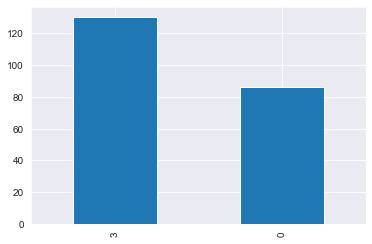

In [5]:
df.relevancy.value_counts().plot(kind='bar')

### For the next steps, it is easier to only use the information on text and relevancy

In [6]:
df = pd.read_csv('export_remigration_06_06_2020_18_57.csv', usecols = ['text','relevancy'])

In [7]:
df.head(5)

,relevancy,text
0,3,Der Leiter der Zweigstelle Wien des Rückwander...
1,0,"„Ober wos denkst denn, so long ausbleibn!“\nFü..."
2,3,"KB. Rom, 9. Dez. Vor der nur zur Hälfte\nbeset..."
3,0,"Innsbruck, 31. Mai. Auf einer Pressefahrt der ..."
4,3,In dieser Lage trat zunächst auch durch die im...


## Clean and tokenize the text (pre-processing) <a class="anchor" id="5-bullet"></a>

Before you can start with the training fo the topic models, you have to clean the text of your newspaper articles. The follwing functions remove punctuations, lower case the text, remove stop words and lemmatize the text. 

#### Stop words: 
You can change the language used for the stop words. You can also add your own stop words or other words you would like to ignore. It helps to ignore words that are often shared in both, relevant and non-relevant articles. 

In [8]:
# Functions to clean, tokenize, and lemmatize the data
def initial_clean(text):
    text = re.sub(r'[^\w\s]','',text)
    text = text.lower() 
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('german')#change the language here
# add your onw stop words
stop_words.extend(["Heimkehr", "Rückkehr", "heimkehren", "zurückkehren", "a", "ab","aber","ach","acht","achte","achten","achter","achtes","ag","alle","allein","allem","allen","aller","allerdings","alles","allgemeinen","als","also","am","an","andere","anderen","andern","anders","au","auch","auf","aus","ausser","außer","ausserdem","außerdem","b","bald","bei","beide","beiden","beim","beispiel","bekannt","bereits","besonders","besser","besten","bin","bis","bisher","bist","c","d","da","dabei","dadurch","dafür","dagegen","daher","dahin","dahinter","damals","damit","danach","daneben","dank","dann","daran","darauf","daraus","darf","darfst","darin","darüber","darum","darunter","das","dasein","daselbst","dass","daß","dasselbe","davon","davor","dazu","dazwischen","dein","deine","deinem","deiner","dem","dementsprechend","demgegenüber","demgemäss","demgemäß","demselben","demzufolge","den","denen","denn","denselben","der","deren","derjenige","derjenigen","dermassen","dermaßen","derselbe","derselben","des","deshalb","desselben","dessen","deswegen","d.h","dich","die","diejenige","diejenigen","dies","diese","dieselbe","dieselben","diesem","diesen","dieser","dieses","dir","doch","dort","drei","drin","dritte","dritten","dritter","drittes","du","durch","durchaus","dürfen","dürft","durfte","durften","e","eben","ebenso","ehrlich","ei","ei,","eigen","eigene","eigenen","eigener","eigenes","ein","einander","eine","einem","einen","einer","eines","einige","einigen","einiger","einiges","einmal","eins","elf","en","ende","endlich","entweder","er","Ernst","erst","erste","ersten","erster","erstes","es","etwa","etwas","euch","f","früher","fünf","fünfte","fünften","fünfter","fünftes","für","g","gab","ganz","ganze","ganzen","ganzer","ganzes","gar","gedurft","gegen","gegenüber","gehabt","gehen","geht","gekannt","gekonnt","gemacht","gemocht","gemusst","genug","gerade","gern","gesagt","geschweige","gewesen","gewollt","geworden","gibt","ging","gleich","gott","gross","groß","grosse","große","grossen","großen","grosser","großer","grosses","großes","gut","gute","guter","gutes","h","habe","haben","habt","hast","hat","hatte","hätte","hatten","hätten","heisst","her","heute","hier","hin","hinter","hoch","i","ich","ihm","ihn","ihnen","ihr","ihre","ihrem","ihren","ihrer","ihres","im","immer","in","indem","infolgedessen","ins","irgend","ist","j","ja","jahr","jahre","jahren","je","jede","jedem","jeden","jeder","jedermann","jedermanns","jedoch","jemand","jemandem","jemanden","jene","jenem","jenen","jener","jenes","jetzt","k","kam","kann","kannst","kaum","kein","keine","keinem","keinen","keiner","kleine","kleinen","kleiner","kleines","kommen","kommt","können","könnt","konnte","könnte","konnten","kurz","l","lang","lange","leicht","leide","lieber","los","m","machen","macht","machte","mag","magst","mahn","man","manche","manchem","manchen","mancher","manches","mann","mehr","mein","meine","meinem","meinen","meiner","meines","mensch","menschen","mich","mir","mit","mittel","mochte","möchte","mochten","mögen","möglich","mögt","morgen","muss","muß","müssen","musst","müsst","musste","mussten","n","na","nach","nachdem","nahm","natürlich","neben","nein","neue","neuen","neun","neunte","neunten","neunter","neuntes","nicht","nichts","nie","niemand","niemandem","niemanden","noch","nun","nur","o","ob","oben","oder","offen","oft","ohne","Ordnung","p","q","r","recht","rechte","rechten","rechter","rechtes","richtig","rund","s","sa","sache","sagt","sagte","sah","satt","schlecht","Schluss","schon","sechs","sechste","sechsten","sechster","sechstes","sehr","sei","seid","seien","sein","seine","seinem","seinen","seiner","seines","seit","seitdem","selbst","sich","sie","sieben","siebente","siebenten","siebenter","siebentes","sind","so","solang","solche","solchem","solchen","solcher","solches","soll","sollen","sollte","sollten","sondern","sonst","sowie","später","statt","t","tag","tage","tagen","tat","teil","tel","tritt","trotzdem","tun","u","über","überhaupt","übrigens","uhr","um","und","und?","uns","unser","unsere","unserer","unter","v","vergangenen","viel","viele","vielem","vielen","vielleicht","vier","vierte","vierten","vierter","viertes","vom","von","vor","w","wahr?","während","währenddem","währenddessen","wann","war","wäre","waren","wart","warum","was","wegen","weil","weit","weiter","weitere","weiteren","weiteres","welche","welchem","welchen","welcher","welches","wem","wen","wenig","wenige","weniger","weniges","wenigstens","wenn","wer","werde","werden","werdet","wessen","wie","wieder","will","willst","wir","wird","wirklich","wirst","wo","wohl","wollen","wollt","wollte","wollten","worden","wurde","würde","wurden","würden","x","y","z","z.b","zehn","zehnte","zehnten","zehnter","zehntes","zeit","zu","zuerst","zugleich","zum","zunächst","zur","zurück","zusammen","zwanzig","zwar","zwei","zweite","zweiten","zweiter","zweites","zwischen","zwölf","euer","eure","hattest","hattet","jedes","mußt","müßt","sollst","sollt","soweit","weshalb","wieso","woher","wohin"])
def remove_stop_words(text):
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] 
    except IndexError: 
        pass
    return text

def apply_all(text):
    return stem_words(remove_stop_words(initial_clean(text)))

In [9]:

df['tokenized'] = df['text'].apply(apply_all) 


## Optional: Reduce your data to nouns, adjectives, verbs, or adverbs  <a class="anchor" id="6-bullet"></a>

This function be can used or be omitted. Sometimes, it makes sense to reduce your data to parts of speech (pos). This depents very much on the research question. To see which method works best, it makes sense to run this program once with and once without pos-tagging. The package Spacy is used for the pos tagging. Spacy can be used in many differnt languages. To use Spazy in your preferred language, you have to install the right model. This model can be found here: https://spacy.io/usage/models

In [10]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

If you don't want to use pos tagging, you can put hashtags in front of the code. 

In [11]:
#nlp = spacy.load('de_core_news_sm', disable=['parser', 'ner'])

#df['tokenized'] = lemmatization(df['tokenized'], allowed_postags=['NOUN', 'ADJ'])

## Have a look at your data <a class="anchor" id="7-bullet"></a>

Check out, if everything went alright so far. Have a look at the tokens, the number of words and their frequency distribution.

In [12]:
df

,relevancy,text,tokenized
0,3,Der Leiter der Zweigstelle Wien des Rückwander...,"[leiter, zweigstel, wien, rückwandereramt, pg,..."
1,0,"„Ober wos denkst denn, so long ausbleibn!“\nFü...","[ober, wo, denkst, long, ausbleibn, getadelten..."
2,3,"KB. Rom, 9. Dez. Vor der nur zur Hälfte\nbeset...","[kb, rom, dez, hälfte, besetzten, kammer, depu..."
3,0,"Innsbruck, 31. Mai. Auf einer Pressefahrt der ...","[innsbruck, 31, mai, pressefahrt, reichsleitun..."
4,3,In dieser Lage trat zunächst auch durch die im...,"[lage, trat, jänner, 1918, beginnend, april, a..."
...,...,...,...
211,3,Davon sind allerdings die Rückwanderer abzuzie...,"[rückwander, abzuziehen, zahl, belief, 190809,..."
212,3,* Beweismaterial gegen die Kriegsgefangenen.\n...,"[beweismateri, kriegsgefangenen, kriegsminist,..."
213,3,Der Austausch der Kriegsgefangenen wird\nim An...,"[austausch, kriegsgefangenen, anschluß, peters..."
214,3,* Das amerikanische Echo. Aus New=York wird\nu...,"[amerikanisch, echo, newyork, geschrieben, mas..."


In [13]:
# first get a list of all words
all_words = [word for item in list(df['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
f"The number of unique words is {len(fdist)}"

'The number of unique words is 8555'

In [14]:
# document length
df['doc_len'] = df['tokenized'].apply(lambda x: len(x))
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

print(f"length of list: {len(doc_lengths)}")
print(f"average document length: {np.average(doc_lengths)}")
print(f"minimum document length: {min(doc_lengths)}")
print(f"maximum document length: {max(doc_lengths)}")

length of list: 216
average document length: 76.98148148148148
minimum document length: 12
maximum document length: 296


## Remove articles that are too short <a class="anchor" id="8-bullet"></a>

To optimize the topic model results, you should avoid to have artcles with less then 30 tokens after cleaning

In [15]:
df = df[df['tokenized'].map(len) >= 30]
# make sure all tokenized items are lists
df = df[df['tokenized'].map(type) == list]
df.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df), "articles")

After cleaning and excluding short aticles, the dataframe now has: 200 articles


In [16]:
df.head()

,relevancy,text,tokenized
0,3,Der Leiter der Zweigstelle Wien des Rückwander...,"[leiter, zweigstel, wien, rückwandereramt, pg,..."
1,0,"„Ober wos denkst denn, so long ausbleibn!“\nFü...","[ober, wo, denkst, long, ausbleibn, getadelten..."
2,3,"KB. Rom, 9. Dez. Vor der nur zur Hälfte\nbeset...","[kb, rom, dez, hälfte, besetzten, kammer, depu..."
3,0,"Innsbruck, 31. Mai. Auf einer Pressefahrt der ...","[innsbruck, 31, mai, pressefahrt, reichsleitun..."
4,3,In dieser Lage trat zunächst auch durch die im...,"[lage, trat, jänner, 1918, beginnend, april, a..."


## Use your dataset to create a training corpus and test corpus <a class="anchor" id="9-bullet"></a>

Before we use our method on a big collection, we use our manual annotated dataset to train the models and to find relevant and non-relevant articles. This helps to control the output (you can compare the output with your manual annotation and see if the program worked correctly) and to adapt the code in order to get the best results for your own collection. 

You can change the size of training and testing corpus by changing the number in following line: msk = np.random.rand(len(df)) < 0.599

In [17]:
# create a mask of binary values
msk = np.random.rand(len(df)) < 0.599

In [18]:
train_df = df[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df[~msk]
test_df.reset_index(drop=True,inplace=True)

In [19]:
print(len(df),len(train_df),len(test_df))

200 141 59


## Create topic models using your training corpus <a class="anchor" id="10-bullet"></a>

The function "train_lda" trains the lda model. You can change the parameters like number of topics or chunksize. To distinguish between relevant and non-relevant articles, a high number of topics is best suited. Of course, this can change from research question to research question, and it makes sense to train your models with a changing number of topics to find out which amount works best for your collection.

We also do several passes of the data since this is a small dataset, so we want the distributions to stabilize. 


In [20]:
def train_lda(data):
    num_topics = 250
    chunksize = 300
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=4)
    t2 = time.time()
    print("Time to train LDA model on ", len(train_df), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [21]:
dictionary,corpus,lda = train_lda(train_df)

Time to train LDA model on  141 articles:  0.24593196709950765 min


Inspect the outcome of your topics. You can see all your topics in changing the topicid to the number of topic you want to see. You can also adapt the number of tokens (topn) by changing the number. 

In [22]:


lda.show_topic(topicid=0, topn=20)



[('fechten', 0.00015812779),
 ('gestützt', 0.00015812779),
 ('don', 0.00015812779),
 ('divisionsgener', 0.00015812779),
 ('del', 0.00015812779),
 ('entsatz', 0.00015812779),
 ('dynastischen', 0.00015812779),
 ('generalstab', 0.00015812779),
 ('feindlichen', 0.00015812779),
 ('feldzug', 0.00015812779),
 ('festung', 0.00015812779),
 ('führte', 0.00015812779),
 ('geboren', 0.00015812779),
 ('gemein', 0.00015812779),
 ('gener', 0.00015812779),
 ('general', 0.00015812779),
 ('generalcapitanat', 0.00015812779),
 ('etappen', 0.00015812779),
 ('ernennung', 0.00015812779),
 ('ernannt', 0.00015812779)]

## Find the dominant topic for each article <a class="anchor" id="11-bullet"></a>

This function will find the most dominant topic for each article in your training corpus. The manual annotated relevance label of each article is includet in the graph. This makes it possible to visualize relevant and non-relevant articles together with their dominant topics. This visualization helps to see how effective the models were trained. The fewer articles share the same dominant topic, the better the results: 



In [23]:
def format_topics_sentences(ldamodel=None, corpus=corpus, relevancy=df['relevancy']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add relevancy to the end of the output
    contents = pd.Series(relevancy)
    
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus, relevancy=df['relevancy'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Relevancy']

# Show
df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Relevancy
0,0,3.0,0.9691,"millionen, lire, schatzminist, umfassenden, st...",3
1,1,124.0,0.9837,"england, demokratischen, deutschen, deutschlan...",0
2,2,60.0,0.9543,"malvinen, geraubten, air, england, bueno, prop...",3
3,3,25.0,0.9620,"heimat, innsbruck, gau, gauleit, hofer, land, ...",0
4,4,124.0,0.9816,"england, demokratischen, deutschen, deutschlan...",3


We save the output as csv and create lists using the numbers of the dominant topic and numbers of the relevancy level

In [24]:
df_dominant_topic.to_csv('topic_relevancy.csv')

In [25]:
import csv

In [26]:
with open('topic_relevancy.csv', 'r') as infile:
    reader = csv.reader(infile)    
    csv_data = list(reader)

In [27]:
df_dominant_topics= pd.read_csv('topic_relevancy.csv', usecols = ['Dominant_Topic', 'Relevancy'])


In [28]:
list_topic = []
for key in csv_data: 
    list_topic.append(key[2])
topic = list_topic[1:]

list_relevancy = []
for key in csv_data:
    list_relevancy.append(key[5])
relevance = list_relevancy[1:]   

Create a network visualization to see how well the dominant topics are separated between relevant (3) and non-relevant (0) articles. This helps to see if your topics are clearly related to the relevant articles or to the non-relevant articles. 

C:\Users\c62255\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


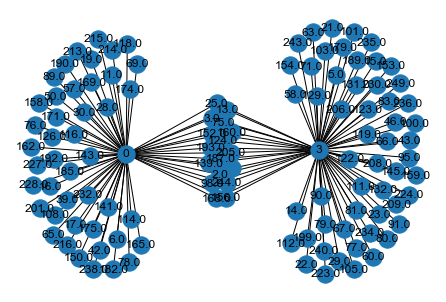

In [29]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Build a dataframe with 4 connections
df = pd.DataFrame({ 'from': relevance, 'to': topic})
df

# Build your graph
G = nx.from_pandas_edgelist(df, 'from', 'to')



# Plot it
nx.draw(G, with_labels=True)
plt.show()

To check out the results, you can also inspect the topics one by one. Choose a topic connected to a relevant article (3) and compare it with a topic conntected to a non-relevant article. If the results do not make sense, restart the kurnel and train the models again. 

In [30]:
lda.show_topic(topicid=99, topn=20)

[('campo', 0.0036293082),
 ('martinez', 0.003377907),
 ('cuba', 0.0021586868),
 ('marschal', 0.001715485),
 ('generalcapitän', 0.0015563607),
 ('mikkelsen', 0.0015240405),
 ('carlisten', 0.0014416635),
 ('norden', 0.0014326458),
 ('gener', 0.00143068),
 ('kapitän', 0.0013902672),
 ('catalonien', 0.0013840827),
 ('kriegsminist', 0.0013550365),
 ('zabala', 0.001346664),
 ('könig', 0.0012891117),
 ('concha', 0.0012343978),
 ('madrid', 0.0012225922),
 ('cubanisch', 0.0011578746),
 ('forscher', 0.0011540791),
 ('arme', 0.0011465874),
 ('alphon', 0.001113876)]

Insepct the shared topics and find out what tokens are often shared between relevant and non-relevant articles (it might help to remove some of these words in order to improve the segmentation) 

In [31]:
# Inspect the shared topics
topic_share = [x for x in set(topic) if topic.count(x) > 1]
print(topic_share)

['', '76.0', '13.0', '3.0', '168.0', '160.0', '2.0', '139.0', '6.0', '152.0', '95.0', '215.0', '118.0', '244.0', '158.0', '124.0', '81.0', '193.0', '249.0', '98.0', '156.0', '75.0', '25.0', '187.0', '205.0']


## Find similar articles using the Jensen Shannon function <a class="anchor" id="12-bullet"></a>

Now lets see if the articles in the test corpus you created are relevant or irrelevant to your research question. Therefore, we compare each unseen article in the test corpus with the topic distribution of the articles in the trained corpus. 

The first function implements a Jensen-Shannon similarity between the input query (an LDA topic distribution for a document)and the entire corpus of topic distributions. It returns an array of length M where M is the number of documents in the corpus. The second function implements the Jensen-Shannon distance above and retruns the top k (in our case 10) indices of the smallest jensen shannon distances. 

### make sure you are using the scipy version 1.3.1

In [32]:
def jensen_shannon(query, matrix):
    p = query[None,:].T 
    q = matrix.T 
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))

In [33]:
def get_most_similar_documents(query,matrix,k=10):
    sims = jensen_shannon(query,matrix) 
    return sims.argsort()[:k] 

Now we compare every single article in the test corpus with the articles in the train corpus. Each useen article gets 10 most similar articles from the training corpus. If 60 percent of the automatically found similar articles were manually annotated as relevant, the new article will be marked as relevant. 
You can change the numner in line: if sum(most_similar_df['relevancy']) > 17. Check out what is happing if you change the number to 14 or 20. 


In [34]:
#create lists for your output

text_relevant = []
number_relevant = []
text_non_relevant = []
number_non_relevant = []

#find most similar articles and select between relevant and non-relevant

index = 0
while index < len(test_df) -1:
    index +=1
    new_bow = dictionary.doc2bow(test_df.iloc[index,2])
    new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])
    doc_topic_dist = np.stack([np.array([tup[1] for tup in lst]) for lst in lda[corpus]])
    doc_topic_dist.shape
    most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist)
    most_similar_df = train_df[train_df.index.isin(most_sim_ids)]
    relevant = []
    if sum(most_similar_df['relevancy']) > 17: 
        text_relevant.append(test_df.iloc[index,1])
        number_relevant.append(test_df.iloc[index,0])
    else:
        text_non_relevant.append(test_df.iloc[index,1])
        number_non_relevant.append(test_df.iloc[index,0])
    pass



In [35]:
#Create a dataframe with the automatically selected relevant and non-relevant articles

df_relevant = pd.DataFrame(np.column_stack([text_relevant, number_relevant]), 
                               columns=['Relevant_Text', 'Real_Relevancy'])

df_non_relevant = pd.DataFrame(np.column_stack([text_non_relevant, number_non_relevant]), 
                               columns=['Unrelevant_Text', 'Real_Revelancy'])


df_results = pd.concat([df_relevant,df_non_relevant], ignore_index=True, axis=1)
df_results.columns=['Relevant_Text', '3','Non_Relevant_Text', '0']
df_results.head(30)

,Relevant_Text,3,Non_Relevant_Text,0
0,Ein Knirps unterm Tropenhelm\n Auf dem Anlegep...,3,"„Ober wos denkst denn, so long ausbleibn!“\nFü...",0
1,Wenn trotzdem süber die Behandlung der Heimkeh...,3,"Innsbruck, 31. Mai. Auf einer Pressefahrt der ...",0
2,Was die materialle Versorgung der Heimkehrer\n...,3,Nachdem Gauleiter Fritz Wächtler die Meldung d...,0
3,Die Austria wird diesmal mit einer starken Elf...,3,"Der Stand der Sonne erinnerte Henriette daran,...",0
4,Walz war im Frühjahr 1920 von der öster\nreich...,3,Die äußeren Ursachen sind bekannt: Die Rückwan...,0
5,"Das ist alles recht schön, aber jedenfalls\nei...",3,"Millionen Soldaten, die im großen Weltkrieg fü...",0
6,"Ein Fall auf dem Dampfer\nTriest, 6. Juni. Ges...",3,Repertoire des Deutschen Volkstheaters. Samsta...,0
7,"Tomaschek war nach Kriegsausbruch eingerückt, ...",3,Seit Harald Paulsen das Theater am Nollendorfp...,0
8,Daß die Versorgung der Heimkehrenden in der\ne...,3,"säule. Zugleich aber fiel das Barometer, und s...",0
9,"Das gesamte deutsche Volk, vorab wir im Gau Ti...",3,.Vom 15. bis 22. Mai veranstaltete die Kreisle...,0


## Calculate the score of the output <a class="anchor" id="13-bullet"></a>

Repeat the calculation (topic models need sometimes several rounds) or adapt the code until you get  a higher score than 80 percent. If you get a higher score than 80 percent, you can continue with your whole dataset. It is recommended to train the models at least twice. 

In [36]:
rev_3 = []
for key in df_results['3']:
    if key == '3':
        rev_3.append(key)
rev_0 = []
for key in df_results['3']:
    if key == '0':
        rev_0.append(key)
non_rev_3 = []
for key in df_results['0']:
    if key == '3':
        non_rev_3.append(key)
non_rev_0 = []
for key in df_results['0']:
    if key == '0':
        non_rev_0.append(key)
result_right = len(non_rev_0) + len(rev_3)
result_wrng = len(non_rev_3) + len(rev_0)
all = len(non_rev_3) + len(rev_0) + len(non_rev_0) + len(rev_3)
score = result_right / all
f"Your score is: {score}"




'Your score is: 0.8275862068965517'

# If your score is higher than 80 percent, you can start to use your whole collection  <a class="anchor" id="14-bullet"></a>

Start with importing your whole collection


In [37]:
df_all = pd.read_csv('export_remigration_all_04_06_2020_04_31.csv', usecols = ['id','language','date','newspaper_id','iiif_url','text'])

In [38]:
df_all = df_all[df_all['text'].map(type) == str]
df_all.dropna(axis=0, inplace=True, subset=['text'])
# shuffle the data
df_all = df_all.sample(frac=1.0)
df_all.reset_index(drop=True,inplace=True)
df_all.head()

,id,language,date,newspaper_id,iiif_url,text
0,neue_freie_presse_nfp19190704_article_531,de,1919-07-04T00:00:00Z,neue_freie_presse,https://platform.newseye.eu/iiif/neue_freie_pr...,"Wien, 3. Juli.\nAus Budapest wird gemeldet: De..."
1,illustrierte_kronen_zeitung_krz19331001_articl...,de,1933-10-01T00:00:00Z,illustrierte_kronen_zeitung,https://platform.newseye.eu/iiif/illustrierte_...,Hosdlt Tei. A-15-0-85: „Nas Trduen naumen.\nMa...
2,arbeiter_zeitung_aze19190828_article_82,de,1919-08-28T00:00:00Z,arbeiter_zeitung,https://platform.newseye.eu/iiif/arbeiter_zeit...,"* Hilfe für die entlassenen Offiziere, die uml..."
3,arbeiter_zeitung_aze19130714_article_149,de,1913-07-14T00:00:00Z,arbeiter_zeitung,https://platform.newseye.eu/iiif/arbeiter_zeit...,Die im Auftrag der ungarischen Sektion der int...
4,neue_freie_presse_nfp18680806_article_115,de,1868-08-06T00:00:00Z,neue_freie_presse,https://platform.newseye.eu/iiif/neue_freie_pr...,"Paris, 3. August. [Orig.=Corr.] (Zur Lage. Bar..."


## Clean (pre-process) your whole collection <a class="anchor" id="15-bullet"></a>

You repeat the same steps you did with your training and testing corpus

In [39]:
# Functions to clean, tokenize, and lemmatize the data
def initial_clean(text):
    text = re.sub(r'[^\w\s]','',text)
    text = text.lower() 
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('german')
# add your onw stop words
stop_words.extend(["Heimkehr", "Rückkehr", "heimkehren", "zurückkehren", "a", "ab","aber","ach","acht","achte","achten","achter","achtes","ag","alle","allein","allem","allen","aller","allerdings","alles","allgemeinen","als","also","am","an","andere","anderen","andern","anders","au","auch","auf","aus","ausser","außer","ausserdem","außerdem","b","bald","bei","beide","beiden","beim","beispiel","bekannt","bereits","besonders","besser","besten","bin","bis","bisher","bist","c","d","da","dabei","dadurch","dafür","dagegen","daher","dahin","dahinter","damals","damit","danach","daneben","dank","dann","daran","darauf","daraus","darf","darfst","darin","darüber","darum","darunter","das","dasein","daselbst","dass","daß","dasselbe","davon","davor","dazu","dazwischen","dein","deine","deinem","deiner","dem","dementsprechend","demgegenüber","demgemäss","demgemäß","demselben","demzufolge","den","denen","denn","denselben","der","deren","derjenige","derjenigen","dermassen","dermaßen","derselbe","derselben","des","deshalb","desselben","dessen","deswegen","d.h","dich","die","diejenige","diejenigen","dies","diese","dieselbe","dieselben","diesem","diesen","dieser","dieses","dir","doch","dort","drei","drin","dritte","dritten","dritter","drittes","du","durch","durchaus","dürfen","dürft","durfte","durften","e","eben","ebenso","ehrlich","ei","ei,","eigen","eigene","eigenen","eigener","eigenes","ein","einander","eine","einem","einen","einer","eines","einige","einigen","einiger","einiges","einmal","eins","elf","en","ende","endlich","entweder","er","Ernst","erst","erste","ersten","erster","erstes","es","etwa","etwas","euch","f","früher","fünf","fünfte","fünften","fünfter","fünftes","für","g","gab","ganz","ganze","ganzen","ganzer","ganzes","gar","gedurft","gegen","gegenüber","gehabt","gehen","geht","gekannt","gekonnt","gemacht","gemocht","gemusst","genug","gerade","gern","gesagt","geschweige","gewesen","gewollt","geworden","gibt","ging","gleich","gott","gross","groß","grosse","große","grossen","großen","grosser","großer","grosses","großes","gut","gute","guter","gutes","h","habe","haben","habt","hast","hat","hatte","hätte","hatten","hätten","heisst","her","heute","hier","hin","hinter","hoch","i","ich","ihm","ihn","ihnen","ihr","ihre","ihrem","ihren","ihrer","ihres","im","immer","in","indem","infolgedessen","ins","irgend","ist","j","ja","jahr","jahre","jahren","je","jede","jedem","jeden","jeder","jedermann","jedermanns","jedoch","jemand","jemandem","jemanden","jene","jenem","jenen","jener","jenes","jetzt","k","kam","kann","kannst","kaum","kein","keine","keinem","keinen","keiner","kleine","kleinen","kleiner","kleines","kommen","kommt","können","könnt","konnte","könnte","konnten","kurz","l","lang","lange","leicht","leide","lieber","los","m","machen","macht","machte","mag","magst","mahn","man","manche","manchem","manchen","mancher","manches","mann","mehr","mein","meine","meinem","meinen","meiner","meines","mensch","menschen","mich","mir","mit","mittel","mochte","möchte","mochten","mögen","möglich","mögt","morgen","muss","muß","müssen","musst","müsst","musste","mussten","n","na","nach","nachdem","nahm","natürlich","neben","nein","neue","neuen","neun","neunte","neunten","neunter","neuntes","nicht","nichts","nie","niemand","niemandem","niemanden","noch","nun","nur","o","ob","oben","oder","offen","oft","ohne","Ordnung","p","q","r","recht","rechte","rechten","rechter","rechtes","richtig","rund","s","sa","sache","sagt","sagte","sah","satt","schlecht","Schluss","schon","sechs","sechste","sechsten","sechster","sechstes","sehr","sei","seid","seien","sein","seine","seinem","seinen","seiner","seines","seit","seitdem","selbst","sich","sie","sieben","siebente","siebenten","siebenter","siebentes","sind","so","solang","solche","solchem","solchen","solcher","solches","soll","sollen","sollte","sollten","sondern","sonst","sowie","später","statt","t","tag","tage","tagen","tat","teil","tel","tritt","trotzdem","tun","u","über","überhaupt","übrigens","uhr","um","und","und?","uns","unser","unsere","unserer","unter","v","vergangenen","viel","viele","vielem","vielen","vielleicht","vier","vierte","vierten","vierter","viertes","vom","von","vor","w","wahr?","während","währenddem","währenddessen","wann","war","wäre","waren","wart","warum","was","wegen","weil","weit","weiter","weitere","weiteren","weiteres","welche","welchem","welchen","welcher","welches","wem","wen","wenig","wenige","weniger","weniges","wenigstens","wenn","wer","werde","werden","werdet","wessen","wie","wieder","will","willst","wir","wird","wirklich","wirst","wo","wohl","wollen","wollt","wollte","wollten","worden","wurde","würde","wurden","würden","x","y","z","z.b","zehn","zehnte","zehnten","zehnter","zehntes","zeit","zu","zuerst","zugleich","zum","zunächst","zur","zurück","zusammen","zwanzig","zwar","zwei","zweite","zweiten","zweiter","zweites","zwischen","zwölf","euer","eure","hattest","hattet","jedes","mußt","müßt","sollst","sollt","soweit","weshalb","wieso","woher","wohin"])
def remove_stop_words(text):
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: 
        pass
    return text

def apply_all(text):
    return stem_words(remove_stop_words(initial_clean(text)))

In [40]:

df_all['tokenized'] = df_all['text'].apply(apply_all) 


## Optional: Reduce your data to nouns, adjectives, verbs, or adverbs <a class="anchor" id="16-bullet"></a> 

This function can used or be omitted. Sometimes, it makes sense to reduce your data to parts of speech (pos). This depents very much on the research question. To see which method works best, it makes sense to run this program once with and once without pos-tagging. We use Spacy for the pos tagging. Spacy can be used in many differnt language. To use Spazy in your preferred language, you have to install the right model. This model can be found here: https://spacy.io/usage/models

In [41]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [42]:
#nlp = spacy.load('de_core_news_sm', disable=['parser', 'ner'])

#df_all['tokenized'] = lemmatization(df_all['tokenized'], allowed_postags=['NOUN'])



### Have a look at your data

Check out, if everything went alright so for. Have a look at the tokens, see the number of words and their frequency distribution.

In [43]:
df_all.head(5)

,id,language,date,newspaper_id,iiif_url,text,tokenized
0,neue_freie_presse_nfp19190704_article_531,de,1919-07-04T00:00:00Z,neue_freie_presse,https://platform.newseye.eu/iiif/neue_freie_pr...,"Wien, 3. Juli.\nAus Budapest wird gemeldet: De...","[wien, juli, budapest, gemeldet, voltskommissä..."
1,illustrierte_kronen_zeitung_krz19331001_articl...,de,1933-10-01T00:00:00Z,illustrierte_kronen_zeitung,https://platform.newseye.eu/iiif/illustrierte_...,Hosdlt Tei. A-15-0-85: „Nas Trduen naumen.\nMa...,"[hosdlt, tei, a15085, na, trduen, naumen, may,..."
2,arbeiter_zeitung_aze19190828_article_82,de,1919-08-28T00:00:00Z,arbeiter_zeitung,https://platform.newseye.eu/iiif/arbeiter_zeit...,"* Hilfe für die entlassenen Offiziere, die uml...","[hilf, entlassenen, offizier, umlernen, staats..."
3,arbeiter_zeitung_aze19130714_article_149,de,1913-07-14T00:00:00Z,arbeiter_zeitung,https://platform.newseye.eu/iiif/arbeiter_zeit...,Die im Auftrag der ungarischen Sektion der int...,"[auftrag, ungarischen, sektion, internationale..."
4,neue_freie_presse_nfp18680806_article_115,de,1868-08-06T00:00:00Z,neue_freie_presse,https://platform.newseye.eu/iiif/neue_freie_pr...,"Paris, 3. August. [Orig.=Corr.] (Zur Lage. Bar...","[pari, august, origcorr, lage, baron, janzé, d..."


In [44]:
# first get a list of all words
all_words = [word for item in list(df_all['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
f"The number of unique words is {len(fdist)}"

'The number of unique words is 23559'

In [45]:
#document length
df_all['doc_len'] = df_all['tokenized'].apply(lambda x: len(x))
doc_lengths = list(df_all['doc_len'])
df_all.drop(labels='doc_len', axis=1, inplace=True)


print(f"length of list: {len(doc_lengths)}")
print(f"average document length: {np.average(doc_lengths)}")
print(f"minimum document length: {min(doc_lengths)}")
print(f"maximum document length: {max(doc_lengths)}")

length of list: 1158
average document length: 57.47409326424871
minimum document length: 1
maximum document length: 446


### Remove articles that are too short 

Avoid articles that are shorter than 30 tokens

In [46]:
df_all = df_all[df_all['tokenized'].map(len) >= 30]
df_all = df_all[df_all['tokenized'].map(type) == list]
df_all.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df_all), "articles")

After cleaning and excluding short aticles, the dataframe now has: 741 articles


In [47]:
df_all.head()

,id,language,date,newspaper_id,iiif_url,text,tokenized
0,neue_freie_presse_nfp19190704_article_531,de,1919-07-04T00:00:00Z,neue_freie_presse,https://platform.newseye.eu/iiif/neue_freie_pr...,"Wien, 3. Juli.\nAus Budapest wird gemeldet: De...","[wien, juli, budapest, gemeldet, voltskommissä..."
1,arbeiter_zeitung_aze19190828_article_82,de,1919-08-28T00:00:00Z,arbeiter_zeitung,https://platform.newseye.eu/iiif/arbeiter_zeit...,"* Hilfe für die entlassenen Offiziere, die uml...","[hilf, entlassenen, offizier, umlernen, staats..."
2,arbeiter_zeitung_aze19130714_article_149,de,1913-07-14T00:00:00Z,arbeiter_zeitung,https://platform.newseye.eu/iiif/arbeiter_zeit...,Die im Auftrag der ungarischen Sektion der int...,"[auftrag, ungarischen, sektion, internationale..."
3,neue_freie_presse_nfp18680806_article_115,de,1868-08-06T00:00:00Z,neue_freie_presse,https://platform.newseye.eu/iiif/neue_freie_pr...,"Paris, 3. August. [Orig.=Corr.] (Zur Lage. Bar...","[pari, august, origcorr, lage, baron, janzé, d..."
4,arbeiter_zeitung_aze19140828_article_131,de,1914-08-28T00:00:00Z,arbeiter_zeitung,https://platform.newseye.eu/iiif/arbeiter_zeit...,* Das amerikanische Echo. Aus New=York wird\nu...,"[amerikanisch, echo, newyork, geschrieben, mas..."


## Calculate similarities in comparing articles to your training corpus   <a class="anchor" id="17-bullet"></a>

In [48]:
def jensen_shannon(query, matrix):
    p = query[None,:].T 
    q = matrix.T 
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))

In [49]:
def get_most_similar_documents(query,matrix,k=10):
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

In [50]:
#create lists for your output
text_relevant = []
number_relevant = []
date_relevant = []
text_non_relevant = []
number_non_relevant = []
language_relevant = []
newspaper_id_relevant = []
iiif_url_relevant = []
id_relevant = []

#find most similar articles and select between relevant and non-relevant

index = 0
while index < len(df_all) -1:
    index +=1
    new_bow = dictionary.doc2bow(df_all.iloc[index,6])
    new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])
    doc_topic_dist = np.stack([np.array([tup[1] for tup in lst]) for lst in lda[corpus]])
    doc_topic_dist.shape
    most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist)
    most_similar_df = train_df[train_df.index.isin(most_sim_ids)]
    # Calculate 
    if sum(most_similar_df['relevancy']) > 17: 
        text_relevant.append(df_all.iloc[index,5])
        date_relevant.append(df_all.iloc[index,2])
        language_relevant.append(df_all.iloc[index,1])
        newspaper_id_relevant.append(df_all.iloc[index,3])
        iiif_url_relevant.append(df_all.iloc[index,4])
        id_relevant.append(df_all.iloc[index,0])
        
    else:
        text_non_relevant.append(df_all.iloc[index,5])
    pass


C:\Users\c62255\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


In [51]:
#transform your lists into a dataframe
df_relevant = pd.DataFrame(np.column_stack([text_relevant]), 
                               columns=['Relevant_Text'])

df_non_relevant = pd.DataFrame(np.column_stack([text_non_relevant]), 
                               columns=['Unrelevant_Text'])


df_results = pd.concat([df_relevant,df_non_relevant], ignore_index=True, axis=1)
df_results.columns=['Relevant_Text','Non_Relevant_Text']
df_results.head(5)

,Relevant_Text,Non_Relevant_Text
0,* Das amerikanische Echo. Aus New=York wird\nu...,"* Hilfe für die entlassenen Offiziere, die uml..."
1,* Empfang österreichischer Heimkehrer aus Rußl...,Die im Auftrag der ungarischen Sektion der int...
2,[Rückgang der Einwanderung in den Vereinigten ...,"Paris, 3. August. [Orig.=Corr.] (Zur Lage. Bar..."
3,gerich\nDie treulose Frau erschossen — vom\nKr...,"Bach, Schlage doch, gewünschte Stunde. Händel,..."
4,Anzeige bei der zuständigen Bezirkshauptmann\n...,[Theater=Nachrichten.] Die Mitglieder des Hofb...


## Export your results to check if the method worked well <a class="anchor" id="18-bullet"></a>

In [52]:
df_results.to_csv('results.csv')

### If you are satisfied with the results, you can save them in the form of your original file <a class="anchor" id="19-bullet"></a>

Otherwise, try to repeat the process

In [53]:
df_final = pd.DataFrame(np.column_stack([id_relevant, language_relevant, newspaper_id_relevant, date_relevant, iiif_url_relevant, text_relevant]), 
                               columns=['id', 'language', 'date', 'newspaper_id', 'iiif_url', 'text'])


df_new = pd.concat([df_final], ignore_index=True, axis=1)
df_new.columns=['id','language', 'date', 'newspaper_id', 'iiif_url', 'text']
df_new.head(5)

,id,language,date,newspaper_id,iiif_url,text
0,arbeiter_zeitung_aze19140828_article_131,de,arbeiter_zeitung,1914-08-28T00:00:00Z,https://platform.newseye.eu/iiif/arbeiter_zeit...,* Das amerikanische Echo. Aus New=York wird\nu...
1,innsbrucker_nachrichten_ibn19200703_article_149,de,innsbrucker_nachrichten,1920-07-03T00:00:00Z,https://platform.newseye.eu/iiif/innsbrucker_n...,* Empfang österreichischer Heimkehrer aus Rußl...
2,neue_freie_presse_nfp19210604_article_978,de,neue_freie_presse,1921-06-04T00:00:00Z,https://platform.newseye.eu/iiif/neue_freie_pr...,[Rückgang der Einwanderung in den Vereinigten ...
3,illustrierte_kronen_zeitung_krz19160426_articl...,de,illustrierte_kronen_zeitung,1916-04-26T00:00:00Z,https://platform.newseye.eu/iiif/illustrierte_...,gerich\nDie treulose Frau erschossen — vom\nKr...
4,illustrierte_kronen_zeitung_krz19210314_articl...,de,illustrierte_kronen_zeitung,1921-03-14T00:00:00Z,https://platform.newseye.eu/iiif/illustrierte_...,Anzeige bei der zuständigen Bezirkshauptmann\n...


## Export your final collection  <a class="anchor" id="29-bullet"></a>

In [54]:
df_new.to_csv('Collection_no_false_positives.csv')